# Testing the gridflag code

This is a more controlled version of the main block in the gridflag.py code. The purpose here is to profile and test the functionality of the aforementioned code.

In [1]:
%matplotlib widget

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

In [3]:
vis = np.load("vis.npy")
psf = np.load("psf.npy")
pcf = np.load("pcf.npy")

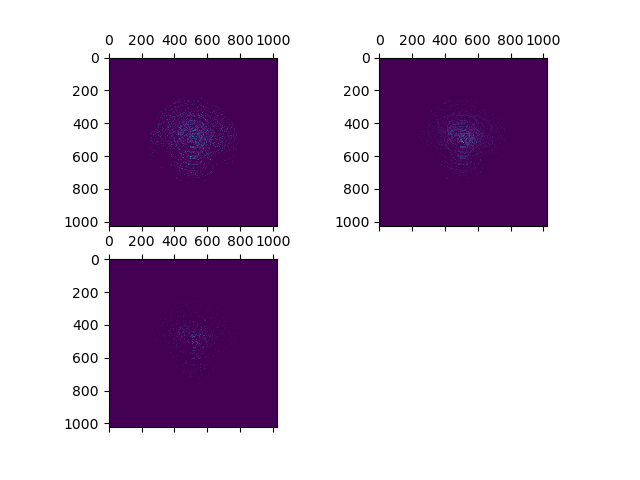

In [4]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.matshow(np.abs(vis[0,0,:,:]))


ax1 = fig.add_subplot(222)
ax1.matshow(np.abs(psf[0,0,:,:]))

ax2 = fig.add_subplot(223)
ax2.matshow(np.abs(pcf[0,0,:,:]))

This is where we'll try and get rid of the loops

In [5]:
pcf_kernel_sizes = np.fabs(np.divide(pcf.imag, pcf.real, where=pcf.real != 0))
pcf_kernel_sizes = np.ceil(pcf_kernel_sizes)
aa_kernel_size = 7
kernel_size_test = (pcf_kernel_sizes != 0) & (pcf_kernel_sizes < aa_kernel_size)
pcf_kernel_sizes[kernel_size_test] += aa_kernel_size

In [6]:
print("Shape: ", pcf_kernel_sizes.shape)
print("DataType: ", pcf_kernel_sizes.dtype)

Shape:  (108, 1, 1024, 1024)
DataType:  float32


In [7]:
box_width = np.ceil(np.amax(pcf_kernel_sizes,axis=(2,3)))

In [8]:
max_filter = np.zeros(pcf.shape, dtype=np.float32)
for i in range(max_filter.shape[0]):
    max_filter[i] = ndimage.maximum_filter(pcf_kernel_sizes[i],
                                        size=(1, box_width[i], box_width[i]),
                                        mode='constant',
                                        cval=0)
max_filter = np.round(max_filter)


In [9]:
max_filter.shape

(108, 1, 1024, 1024)

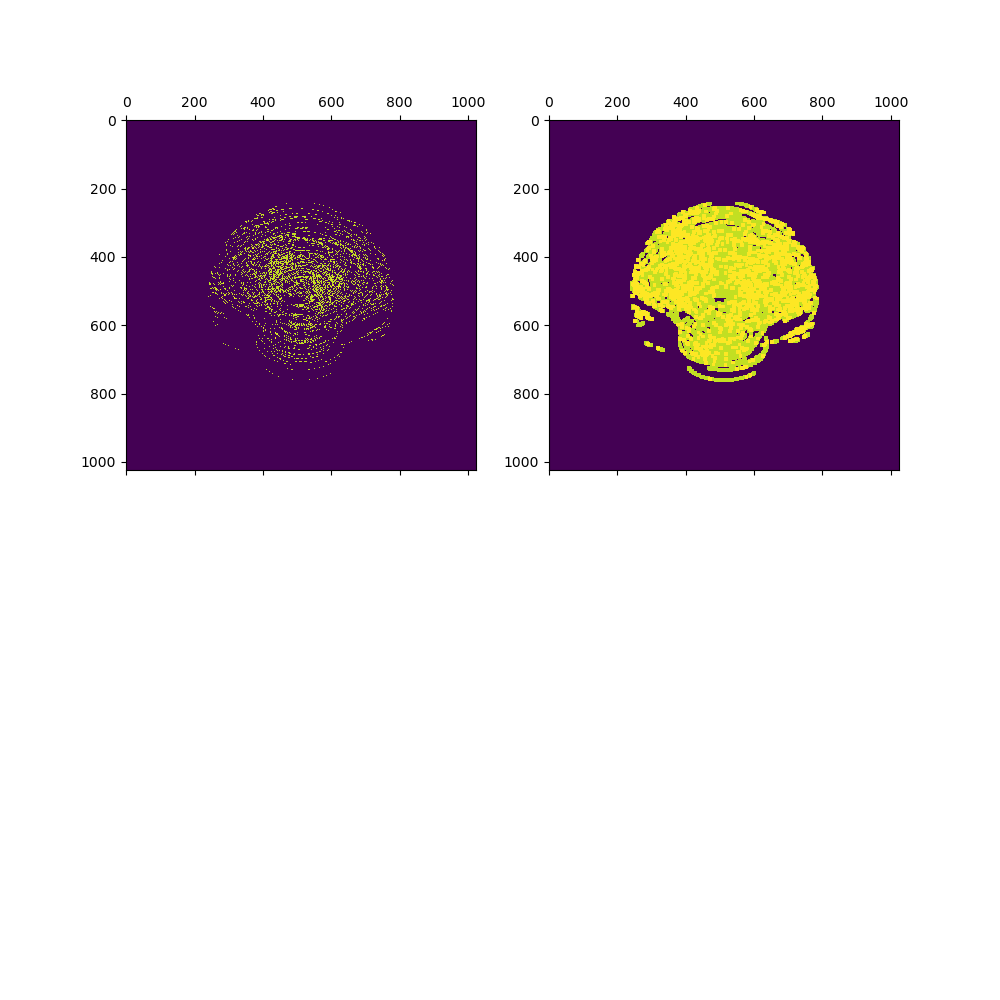

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
ax.matshow(pcf_kernel_sizes[0,0,:,:])

ax1 = fig.add_subplot(222)
ax1.matshow(max_filter[0,0,:,:])


x = 11 -> 1012
y = 11 -> 1012
boxStartx = 5 -> 1006
boxStarty = 5 -> 1006

xb = (5 -> 1006) -> (16 -> 1017)

In [11]:
xrange = np.array([2*box_width/2, pcf.shape[2] - 2*box_width/2], dtype=np.int32).T
yrange = np.array([2*box_width/2, pcf.shape[3] - 2*box_width/2], dtype=np.int32).T

for now we will assume each channel has separate width

In [203]:
smeared_grid = np.zeros(pcf.shape)
for i in range(1):#xrange.shape[1]):
    
    x,y = np.mgrid[xrange[0,i,0]:xrange[0,i,1],yrange[0,i,0]:yrange[0,i,1]]
    # # per grid cell
    # # kernel
    rxk, ryk = np.mgrid[0:box_width[i], 0:box_width[i]]
    xbk = ((x-box_width[i]/2)[..., None, None] + rxk[None, None, ...]).astype(np.int32)
    ybk = ((y-box_width[i]/2)[..., None, None] + ryk[None, None, ...]).astype(np.int32)
    kernelW = np.round(np.max(pcf_kernel_sizes[i,0, xbk, ybk]))
    kernelW = np.fmax(kernelW, max_filter[i, 0, xrange[0,i,0]:xrange[0,i,1],yrange[0,i,0]:yrange[0,i,1]])
    mask = kernelW > 0
    d2mask = mask
    regionW = np.zeros(kernelW.shape)
    regionW[mask] = 1 + 2*(kernelW[mask]-1)
    local_radius_sq = np.zeros(kernelW.shape)
    local_radius_sq[mask] = 0.25 * kernelW[mask]**2
    region_radius_sq = np.zeros(regionW.shape)
    region_radius_sq[mask] = 0.25 * regionW[mask]**2
    # val
    rx,ry = np.mgrid[0:np.max(regionW[mask]), 0:np.max(regionW[mask])]
    xb = np.zeros((x.shape[0], x.shape[1], rx.shape[0], ry.shape[1]), dtype=np.int32)
    xb[mask, :,:] = ((x[mask]-regionW[mask]/2)[...,None,None]+rx[None,None,...]).astype(np.int32)
    yb = np.zeros((y.shape[0], y.shape[1], rx.shape[0], ry.shape[1]), dtype=np.int32)
    yb[mask, :,:] = ((y[mask]-regionW[mask]/2)[...,None,None]+ry[None,None,...]).astype(np.int32)
    mask = np.bitwise_and(mask[..., None, None], xb < (x-1+regionW/2)[..., None, None])
    mask = np.bitwise_and(mask, yb < (y-1+regionW/2)[..., None, None])
    val = np.zeros((x.shape[0], y.shape[1], rx.shape[0], ry.shape[1]))
    val[mask] = pcf[i, 0, xb[mask], yb[mask]].real
    mask = np.bitwise_and(mask, val > 0)
    # rsq (These had to be split up so my kernel didn't die from memory saturation)
    dx = np.zeros(val.shape, dtype=np.float32)
    dx[..., 0 , 0][d2mask] = np.floor(x[d2mask] - regionW[d2mask]/2) + regionW[d2mask]/2
    dx[...] = dx[..., 0, 0][..., None, None]
    dx[~mask] = 0
    dx[mask] = xb[mask]-dx[mask]
    dx[mask] = np.power(dx[mask], 2)
    dy = np.zeros(val.shape, dtype=np.float32)
    dy[..., 0 , 0][d2mask] = np.floor(y[d2mask] - regionW[d2mask]/2) + regionW[d2mask]/2
    dy[...] = dy[..., 0, 0][..., None, None]
    dy[~mask] = 0
    dy[mask] = yb[mask]-dy[mask]
    dy[mask] = np.power(dy[mask], 2)
    
    rsq = dx + dy
    # region_count
    mask = np.bitwise_and(mask, rsq <= region_radius_sq[..., None, None])
    region_count = mask.sum(axis=(2,3))
    # # region_sum
    val[~mask] = 0
    region_sum = val.sum(axis=(2,3), where=mask, dtype=np.float32)
    # # local count
    mask = np.bitwise_and(mask, rsq <= local_radius_sq[..., None, None])
    local_count = mask.sum(axis=(2,3))
    local_count_cond = np.zeros(pcf.shape[2:],dtype=np.bool_)
    local_count_cond[xrange[0,i,0]:xrange[0,i,1], yrange[0,i,0]:yrange[0,i,1]] = local_count > 0
    smeared_grid[i, 0,local_count_cond] = (region_sum/region_count)[local_count > 0]


/var/folders/r_/5_7vfq057t5g1s7xy9hsbhd518n8zd/T/ipykernel_74491/3655866392.py:58: RuntimeWarning: invalid value encountered in divide
  smeared_grid[i, 0,local_count_cond] = (region_sum/region_count)[local_count > 0]


In [210]:
kernelW.shape

(1002, 1002)

In [207]:
initial_pcf_grid_array = pcf
smeared_grid_orig = np.zeros(np.shape(initial_pcf_grid_array))

# Split the data to real and imaginary part
pcf_real = np.real(initial_pcf_grid_array[:,0,...])
pcf_imag = np.imag(initial_pcf_grid_array[:,0,...])

# Perform the operations by channel
for i in range(1):#0,np.shape(pcf_imag)[0]):
    # Loop trough the grid cells
    for x in range(xrange[0,i,0], xrange[0,i,1]):

        boxStart0 = int(np.floor(x - box_width[i]/2))

        for y in range(yrange[0,i,0], yrange[0,i,1]):

            region_count = 0.
            region_sum = 0.
            local_count = 0

            # Get the local max kernel manually
            boxStart1 = int(np.floor(y - box_width[i]/2))

            kernelW_orig = 0.
            for xb in range(boxStart0, int(np.ceil(boxStart0 + box_width[i]))):
                for yb in range(boxStart1, int(np.ceil(boxStart1 + box_width[i]))):
                    kernelW_orig = np.max([kernelW_orig, pcf_kernel_sizes[i,0,xb,yb]])

            kernelW_orig = np.round(kernelW_orig)

            if kernelW_orig != max_filter[i, 0,x,y]:
                # print(kernelW, C_max_local_matrix[x,y])

                kernelW_orig = np.amax([kernelW_orig, max_filter[i, 0,x,y]])


            # If the local max kernel size is 0 pass
            if kernelW_orig > 0:
                # kernelWidth = C_max_local_matrix[x,y]
                kernelWidth = kernelW_orig

                regionWidth = 1 + 2 * (kernelWidth - 1)

                boxStart0 = int(np.floor(x - regionWidth/2))  # Added floor
                boxStart1 = int(np.floor(y - regionWidth/2))

                localRadiusSq = 0.25 * kernelWidth*kernelWidth
                regionRadiusSq = 0.25 * regionWidth*regionWidth

                # Loop trough the sub-box
                for xb in range(boxStart0, int(boxStart0 + regionWidth)):
                    dx2 = np.power(xb - boxStart0 - regionWidth/2, 2)

                    for yb in range(boxStart1, int(boxStart1 + regionWidth)):
                        dy2 = np.power(yb - boxStart1 - regionWidth/2, 2)

                        val = pcf_real[i,xb,yb]

                        if val > 0:
                            rsq = dx2 + dy2


                            # This part should be different for the smearing, but good for the Wiener-filetring
                            if rsq <= regionRadiusSq:

                                region_count += 1
                                region_sum += val
                                # The rounding (?) is new compared to the C++ code (?)

                                # print(rsq, localRadiusSq) #There are possibly some errors here

                                # If the point is in the local kernel radius (slightly
                                # larger radius, actually)
                                if rsq <= localRadiusSq:
                                    local_count += 1

            if local_count > 0:
                # Now add the region_sum to the new array
                smeared_grid_orig[i,0,x,y] = region_sum/region_count

In [208]:
ref_grid_occ = np.where(np.abs(vis[0,0,...]) > 0, 1, 0)
smeared_grid_occ = np.where(smeared_grid[0,0,...] > 0, 2, 0)
smeared_grid_occ_orig = np.where(smeared_grid_orig[0,0,...] > 0, 2, 0)

diff_grid = np.subtract(ref_grid_occ, smeared_grid_occ)
diff_grid_orig = np.subtract(ref_grid_occ, smeared_grid_occ_orig)

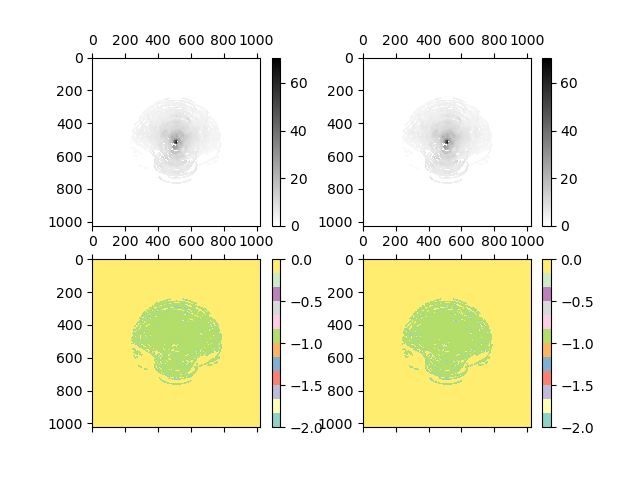

In [209]:
fig = plt.figure()
ax = fig.add_subplot(221)
p = ax.matshow(smeared_grid[0,0], cmap='gray_r')
plt.colorbar(p)

ax1 = fig.add_subplot(222)
p1 = ax1.matshow(smeared_grid_orig[0,0], cmap='gray_r')
plt.colorbar(p1)

ax2 = fig.add_subplot(223)
p2 = ax2.matshow(diff_grid, cmap='Set3')
plt.colorbar(p2)

ax3 = fig.add_subplot(224)
p3 = ax3.matshow(diff_grid, cmap='Set3')
plt.colorbar(p3)

In [47]:
plt.close('all')